### Clean Data for Time Series

In [31]:
import pandas as pd

sales_df = pd.read_csv('sales.csv')
sales_df.head()



,date,sales
0,2022-09-03 17:10:08.079328,55.292157
1,2022-09-04 17:10:08.079328,53.803211
2,2022-09-05 17:10:08.079328,58.141693
3,2022-09-06 17:10:08.079328,64.530899
4,2022-09-07 17:10:08.079328,66.013633


In [32]:
sales_df['date'] = pd.to_datetime(sales_df['date']).dt.normalize()
sales_df.set_index('date', drop=True, inplace=True)
sales_df.head()

,sales
date,
2022-09-03,55.292157
2022-09-04,53.803211
2022-09-05,58.141693
2022-09-06,64.530899
2022-09-07,66.013633


### Visualize Time Series 

<Axes: xlabel='date', ylabel='sales'>

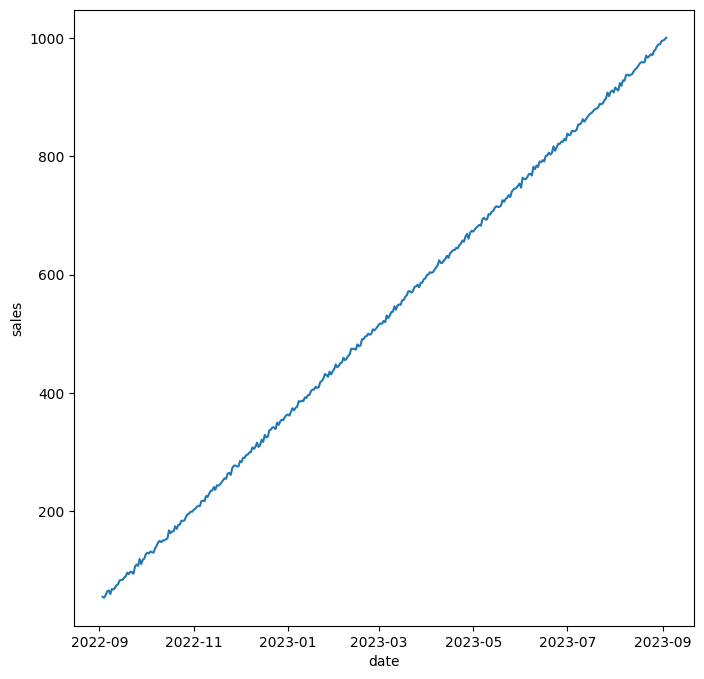

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns 

fig, axis = plt.subplots(figsize = (8,8))
target = sales_df['sales']
sns.lineplot(data=target)

In [34]:
sales_df.shape

(366, 1)

Tensor = 1 day <br>
Trend = Positive <br>
Non Stationary Data <br>
Slight Variability 

In [35]:
#%pip install statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(target, period=12)
decomposition

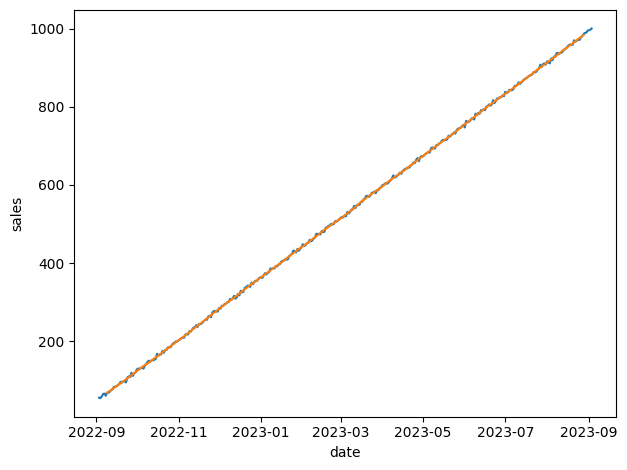

In [36]:
trend = decomposition.trend

sns.lineplot(data = target)
sns.lineplot(data = trend)

plt.tight_layout()

plt.show()

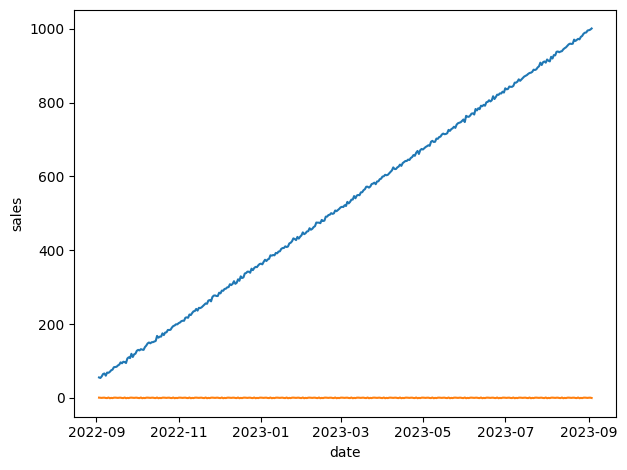

In [37]:
seasonality = decomposition.seasonal

sns.lineplot(data = target)
sns.lineplot(data = seasonality)

plt.tight_layout()

plt.show()

In [38]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    print("Dickey-Fuller test results:")
    dftest = adfuller(timeseries, autolag = "AIC")
    dfoutput = pd.Series(dftest[0:4], index = ["Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])
    for key,value in dftest[4].items():
        dfoutput["Critical Value (%s)"%key] = value
    return dfoutput

test_stationarity(target)

Dickey-Fuller test results:


Test Statistic                   0.545414
p-value                          0.986190
#Lags Used                      13.000000
Number of Observations Used    352.000000
Critical Value (1%)             -3.449065
Critical Value (5%)             -2.869786
Critical Value (10%)            -2.571163
dtype: float64

P value statistically significant 

### ARIMA Model Training

In [39]:
sales_df_stationary = sales_df.diff().dropna()
test_stationarity(sales_df_stationary)

Dickey-Fuller test results:


Test Statistic                -9.430263e+00
p-value                        5.212954e-16
#Lags Used                     1.200000e+01
Number of Observations Used    3.520000e+02
Critical Value (1%)           -3.449065e+00
Critical Value (5%)           -2.869786e+00
Critical Value (10%)          -2.571163e+00
dtype: float64

In [40]:
sales_df.head()

,sales
date,
2022-09-03,55.292157
2022-09-04,53.803211
2022-09-05,58.141693
2022-09-06,64.530899
2022-09-07,66.013633


### Test Train Split

In [41]:
# from sklearn.model_selection import train_test_split

# sales_df = sales_df.sort_index()

# X = sales_df.drop(columns='sales')
# y = sales_df['sales']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# y_train.head()



In [42]:
from sktime.forecasting.model_selection import temporal_train_test_split 

X = sales_df.drop(columns='sales')
y = sales_df['sales']

y_train, y_test = temporal_train_test_split(y, test_size=0.2)

y_test.head()

date
2023-06-22    816.911750
2023-06-23    809.422692
2023-06-24    814.797630
2023-06-25    821.218893
2023-06-26    820.704134
Name: sales, dtype: float64

Data is stationary at 5.21%

In [43]:

import warnings 
import itertools
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
#from pmdarima import auto_arima  # Import auto_arima

# Suppress warnings to keep output clean
warnings.filterwarnings("ignore")

# Example time series data
# Replace this with your actual time series data
# Ensure your data is in a Pandas Series format
# e.g., ts = pd.Series(your_time_series_data)
ts = pd.Series(y_train)  # Random data as an example

# Define the range for p, d, and q (can be adjusted as needed)
p = range(0, 4)  # Autoregressive term (p)
d = range(0, 2)  # Differencing term (d)
q = range(0, 4)  # Moving average term (q)

# Create a list of all possible (p, d, q) combinations
pdq = list(itertools.product(p, d, q))

# Initialize variables to store the best model and lowest AIC
best_aic = float("inf")
best_order = None
best_model = None

# Grid search over all combinations of p, d, q
for param in pdq:
    try:
        # Fit the ARIMA model for each (p, d, q) combination
        model = ARIMA(ts, order=param)
        model_fit = model.fit()
        
        # Get the AIC of the fitted model
        aic = model_fit.aic
        
        # Print the AIC value and the corresponding (p, d, q)
        print(f"ARIMA{param} AIC={aic}")
        
        # Save the best model (lowest AIC)
        if aic < best_aic:
            best_aic = aic
            best_order = param
            best_model = model_fit
    except Exception as e:
        # Print the error if model fitting fails for a specific (p, d, q)
        print(f"ARIMA{param} failed: {e}")
        continue

# Print the best ARIMA model found
print(f"\nBest ARIMA model: ARIMA{best_order} with AIC={best_aic}")
arima = auto_arima(test_stationarity, seasonal = True, trace=True, m=12)

ARIMA(0, 0, 0) AIC=3980.301601674275
ARIMA(0, 0, 1) AIC=3599.6887058725633
ARIMA(0, 0, 2) AIC=3284.040849654218
ARIMA(0, 0, 3) AIC=3082.7685080746805
ARIMA(0, 1, 0) AIC=1763.7613182382981
ARIMA(0, 1, 1) AIC=1762.9243860770534
ARIMA(0, 1, 2) AIC=1730.9134215328268
ARIMA(0, 1, 3) AIC=1713.3235289402942
ARIMA(1, 0, 0) AIC=1782.4332984301661
ARIMA(1, 0, 1) AIC=1781.7153841169397
ARIMA(1, 0, 2) AIC=1749.5887029781147
ARIMA(1, 0, 3) AIC=1731.9987851726169
ARIMA(1, 1, 0) AIC=1761.0985573800021
ARIMA(1, 1, 1) AIC=1683.0919771095553
ARIMA(1, 1, 2) AIC=1490.581734792922
ARIMA(1, 1, 3) AIC=1489.6864060179996
ARIMA(2, 0, 0) AIC=1779.7749355633898
ARIMA(2, 0, 1) AIC=1776.7028661521817
ARIMA(2, 0, 2) failed: LU decomposition error.
ARIMA(2, 0, 3) AIC=1552.9151810478452
ARIMA(2, 1, 0) AIC=1737.2825636366317
ARIMA(2, 1, 1) AIC=1587.4275747250758
ARIMA(2, 1, 2) AIC=1490.1424551048872
ARIMA(2, 1, 3) AIC=1494.5694918845925
ARIMA(3, 0, 0) AIC=1756.0418265607125
ARIMA(3, 0, 1) AIC=12.0
ARIMA(3, 0, 2) AIC=1

NameError: name 'auto_arima' is not defined

In [23]:
# model = ARIMA(y_train, order=(3, 0, 1))
# model_fit = model.fit()

In [50]:
from sklearn.metrics import mean_squared_error

# Forecast for the test period
forecast = model_fit.forecast(steps=len(y_test))

# Evaluate the model
mse = mean_squared_error(y_test, forecast)
print(mse)
model_fit.summary()

8.376629437278188


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  sales   No. Observations:                  292
Model:                 ARIMA(3, 1, 3)   Log Likelihood                -739.656
Date:                Mon, 07 Oct 2024   AIC                           1493.311
Time:                        23:40:40   BIC                           1519.024
Sample:                    09-03-2022   HQIC                          1503.612
                         - 06-21-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0869      0.060     -1.460      0.144      -0.204       0.030
ar.L2          0.9989      0.007    139.975      0.000       0.985       1.013
ar.L3          0.0880      0.059      1.484      0.138      -0.028       0.204
ma.L1         -0.9138      0.033    -27.897      0.000      -0.978      -0.850
ma.L2         -0.9975      0.021    -47.761      0.000      -1.038      -0.957
ma.L3          0.9126      0.032     28.814      0.000       0.850       0.975
sigma2         9.1016      0.855     10.648      0.000       7.426      10.777
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                 1.95
Prob(Q):                              0.85   Prob(JB):                         0.38
Heteroskedasticity (H):               0.95   Skew:                             0.05
Prob(H) (two-sided):                  0.79   Kurtosis:                         2.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
model = model.predict()

### Plot Actual vs Forecast

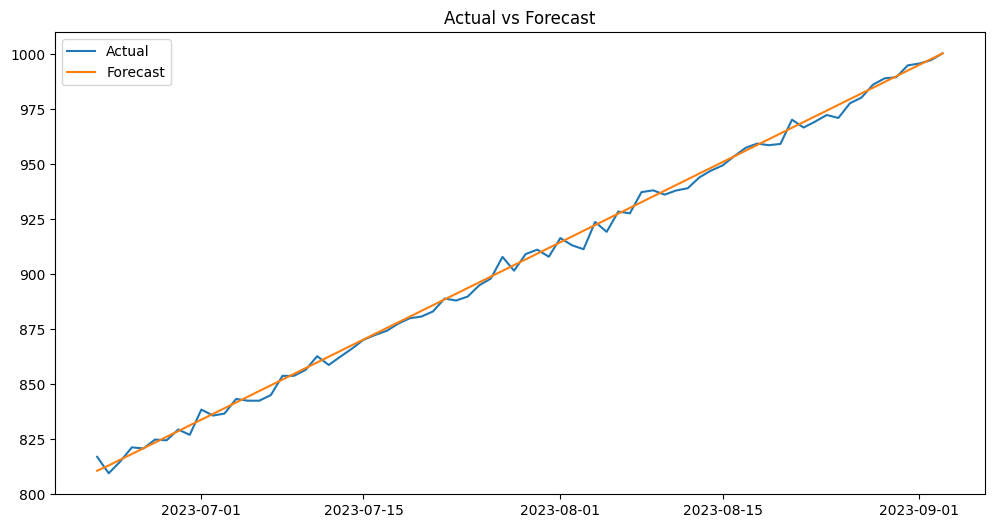

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(y_test.index, y_test.values, label='Actual')
plt.plot(y_test.index, forecast, label='Forecast')
plt.legend()
plt.title('Actual vs Forecast')
plt.show()

In [48]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

mse = mean_squared_error(y_test, forecast)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, forecast)
mape = np.mean(np.abs((y_test - forecast) / y_test)) * 100

print(f'MSE: {mse:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'MAE: {mae:.2f}')
print(f'MAPE: {mape:.2f}%')

MSE: 8.38
RMSE: 2.89
MAE: 2.34
MAPE: 0.26%


In [47]:
import pickle

with open('arima_model.pkl', 'wb') as file:
    pickle.dump(model_fit, file)